# Emotion Recognition from EEG Signals – GAMEEMO Dataset

This notebook demonstrates a **complete baseline pipeline** to train a discrete‐emotion classifier on the [GAMEEMO](https://www.kaggle.com/datasets/sigfest/database-for-emotion-recognition-system-gameemo) EEG dataset. The goal is to predict the **game‐elicited emotion** category:

* **Boring** (G1)
* **Calm** (G2)
* **Horror** (G3)
* **Funny** (G4)

In [1]:
import os, re, sys, subprocess, warnings
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.signal import welch, butter, filtfilt

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_samples
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import joblib

warnings.filterwarnings("ignore")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)
print("Running on", device)

Running on cpu


## 1 Dataset

In [2]:
DATA_ROOT = Path("../data/GAMEEMO")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

if not any(DATA_ROOT.rglob("*.csv")):
    print("Downloading GAMEEMO")
    try:
        subprocess.run(
            [
                "kaggle",
                "datasets",
                "download",
                "-d",
                "sigfest/database-for-emotion-recognition-system-gameemo",
                "-p",
                str(DATA_ROOT.parent),
                "--unzip",
            ],
            check=True,
        )
    except Exception as e:
        sys.stderr.write(f"⚠️ Kaggle download failed: {e}\n")
else:
    print("Dataset already present - skipping download.")

Dataset already present - skipping download.


## 2 File / channel sanity‑check

In [3]:
GAME_ID_TO_LABEL = {"G1": "Boring", "G2": "Calm", "G3": "Horror", "G4": "Funny"}
label2idx = {v: i for i, v in enumerate(GAME_ID_TO_LABEL.values())}
idx2label = {i: l for l, i in label2idx.items()}


def label_from_path(p: Path):
    m = re.search(r"G[1-4]", p.stem, re.I)
    if m:
        return GAME_ID_TO_LABEL[m.group(0).upper()]
    for l in GAME_ID_TO_LABEL.values():
        if l.lower() in p.stem.lower():
            return l
    raise ValueError(f"No label for {p}")

In [4]:
# Only pre‑processed EEG CSVs (each file = one emotion run)
csv_files = sorted(
    [
        p
        for p in DATA_ROOT.rglob("*.csv")
        if "Preprocessed" in p.as_posix() and "Raw" not in p.as_posix()
    ]
)
print("Files found:", len(csv_files))


# Determine intersection of numeric EEG channels across every CSV
common_cols = None
for fp in csv_files:
    cols = set(pd.read_csv(fp, nrows=1).select_dtypes("number").columns)
    common_cols = cols if common_cols is None else (common_cols & cols)
common_cols = sorted(common_cols)
N_CH = len(common_cols)
print("Shared channels:", N_CH, common_cols)

FS, WIN_SEC = 128, 3  # GAMEEMO constants
WIN_SAMP = FS * WIN_SEC

Files found: 116
Shared channels: 15 ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8', 'Unnamed: 14']


In [5]:
# Load raw EEG CSV files (each file = one emotion run)
raw_csv_files = sorted(
    [
        p
        for p in DATA_ROOT.rglob("*.csv")
        if "Raw" in p.as_posix()
    ]
)
print("Raw files found:", len(raw_csv_files))

# Optional: check shared numeric columns across raw CSVs
raw_common_cols = None
for fp in raw_csv_files:
    cols = set(pd.read_csv(fp, nrows=1).select_dtypes("number").columns)
    raw_common_cols = cols if raw_common_cols is None else (raw_common_cols & cols)
raw_common_cols = sorted(raw_common_cols)
print("Shared RAW channels:", len(raw_common_cols), raw_common_cols)


Raw files found: 116
Shared RAW channels: 14 ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']


In [6]:
# Band-pass filter function (0.5-50 Hz)
def bandpass_filter(data, lowcut=0.5, highcut=50.0, fs=128, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, data, axis=0)

# Function to normalize data (z-score)
def normalize_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)  # Standardizes to have zero mean and unit variance

# Function to segment the data into epochs (windows)
def segment_into_epochs(data, fs=128, win_sec=3):
    window_size = fs * win_sec
    num_epochs = len(data) // window_size
    # Reshape the data into windows (epochs)
    epochs = data[:num_epochs * window_size].reshape(num_epochs, window_size, -1)
    return epochs

# Main function to preprocess raw EEG data
def preprocess_raw_file(raw_fp, common_cols, fs=FS, win_sec=WIN_SEC):
    # Load raw EEG data
    raw_df = pd.read_csv(raw_fp)
    
    # Extract the relevant EEG channels (common_cols)
    raw_data = raw_df[common_cols].dropna().to_numpy()
    
    # Step 1: Apply Band-pass Filter (0.5-50 Hz)
    filtered_data = bandpass_filter(raw_data, lowcut=0.5, highcut=50.0, fs=fs)
    
    # Step 2: Segment the filtered data into epochs (windows)
    epochs = segment_into_epochs(filtered_data, fs=fs, win_sec=win_sec)
    
    # Step 3: Normalize the data (z-score)
    # normalized_epochs = np.array([normalize_data(epoch) for epoch in epochs])
    
    return epochs #normalized_epochs  # Return preprocessed epochs



In [7]:
# Compare the custom preprocessed data with official preprocessed data
def compare_preprocessing(raw_fp, preproc_fp, common_cols):
    # Preprocess raw data
    raw_windows = preprocess_raw_file(raw_fp, raw_common_cols, fs=FS, win_sec=WIN_SEC)
    raw_flat = raw_windows.reshape(-1, raw_windows.shape[-1])  # flatten to (samples, channels)
    
    # Load official preprocessed data
    preproc_df = pd.read_csv(preproc_fp)[common_cols].dropna()
    preproc_data = preproc_df.to_numpy()
    
    # Match lengths
    min_len = min(len(raw_flat), len(preproc_data))
    if min_len < 2:
        raise ValueError(f"Not enough data to compare: min length = {min_len}")
    
    raw_flat = raw_flat[:min_len]
    preproc_data = preproc_data[:min_len]

    # Return the datasets
    return raw_flat, preproc_data

# Function to plot comparison of the three datasets
def plot_channel_comparison(raw_data, preproc_data, raw_data_unprocessed, channel_idx=0, ch_name=""):
    plt.figure(figsize=(12, 4))
    
    # Plot Raw Data (unprocessed)
    plt.plot(raw_data_unprocessed[:, channel_idx], label="Raw Data", alpha=0.5, color="gray")
    
    # Plot Custom Preprocessed Data
    plt.plot(raw_data[:, channel_idx], label="Custom Preprocessed", alpha=0.7)
    
    # Plot Official Preprocessed Data
    plt.plot(preproc_data[:, channel_idx], label="Official Preprocessed", alpha=0.7)
    
    plt.title(f"Channel {ch_name or channel_idx} - Raw vs Custom vs Official")
    plt.legend()
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude (normalized)")
    plt.grid(True)
    plt.show()

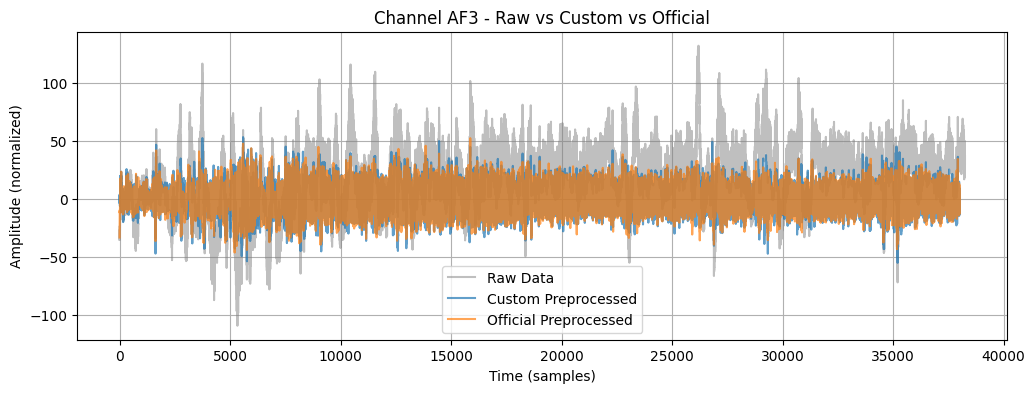

In [8]:
# Step 1: Choose a raw file and its matching preprocessed file
raw_fp = raw_csv_files[0]  # Update to select the desired raw file
stem = raw_fp.stem.replace("Raw", "")
matched_preproc = [p for p in csv_files if stem in p.stem][0]  # Match the preprocessed file

# Step 2: Compare preprocessing between raw and official preprocessed
raw_data, preproc_data = compare_preprocessing(raw_fp, matched_preproc, raw_common_cols)

# Step 3: Load the raw unprocessed data for comparison
raw_df = pd.read_csv(raw_fp)
raw_data_unprocessed = raw_df[raw_common_cols].dropna().to_numpy()

# Step 4: Plot comparison for a specific channel (example: 'AF3')
plot_channel_comparison(raw_data, preproc_data, raw_data_unprocessed, channel_idx=0, ch_name=common_cols[0])

## 3 Feature helpers

In [9]:
# ---------- Helper functions ----------------------------------------
def iter_windows(arr, win_len):
    """Yield consecutive, non-overlapping windows of fixed length."""
    n_win = len(arr) // win_len
    for i in range(n_win):
        yield arr[i * win_len : (i + 1) * win_len]


BANDS = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30),
    "gamma": (30, 45),
}
N_B = len(BANDS)


def stat_features(windows):
    """Per-channel mean/std/var/skew/kurt - returned shape (n_win, ch*5)."""
    feats = []
    for w in windows:
        f = []
        for ch in range(N_CH):
            x = w[ch]
            f.extend([x.mean(), x.std(), x.var(), skew(x), kurtosis(x)])
        feats.append(f)
    return np.asarray(feats, np.float32)


def band_features(windows):
    """Sum of PSD inside canonical EEG sub-bands for each channel."""
    feats = []
    for w in windows:
        row = []
        for ch in range(N_CH):
            f, p = welch(w[ch], FS, nperseg=WIN_SAMP)
            for lo, hi in BANDS.values():
                row.append(p[(f >= lo) & (f <= hi)].sum())
        feats.append(row)
    return np.asarray(feats, np.float32)


def clean(arr):
    """Replace NaN/Inf with 0, operate in-place."""
    np.nan_to_num(arr, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    return arr

### 3.1 Build dataset

In [10]:
stat_all, band_all, raw_all, y_all, groups = [], [], [], [], []

for file_idx, fp in enumerate(tqdm(csv_files, desc="building")):
    label = label_from_path(fp)
    df = pd.read_csv(fp, usecols=common_cols)
    sig = df.to_numpy(np.float32)

    # Channel‑wise z‑score (helps CNN converge)
    sig = (sig - sig.mean(0)) / (sig.std(0) + 1e-6)

    # Generate windows
    windows = list(iter_windows(sig, WIN_SAMP))
    if not windows:
        continue
    windows = np.stack(windows)  # (n_win, time, ch)
    windows = windows.transpose(0, 2, 1)  # (n_win, ch, time) – CNN expects (B,C,T)

    # Hand‑crafted features
    stats = clean(stat_features(windows))
    bands = clean(band_features(windows))

    n_win = len(windows)
    stat_all.append(stats)
    band_all.append(bands)
    raw_all.append(windows)
    y_all.append(np.full(n_win, label2idx[label]))
    groups.extend([file_idx] * n_win)  # file index acts as "group"

X_stat = np.concatenate(stat_all)
X_band = np.concatenate(band_all)
X_raw = np.concatenate(raw_all)
y = np.concatenate(y_all)
groups = np.asarray(groups)

X_comb = clean(np.concatenate([X_stat, X_band], 1))

print("Windows total:", len(y))

building: 100%|██████████| 116/116 [05:23<00:00,  2.79s/it]

Windows total: 11484


### 3.2 Exploratory Data Analysis 

Before building our new model we take a brief look at the data distribution and the feature space.


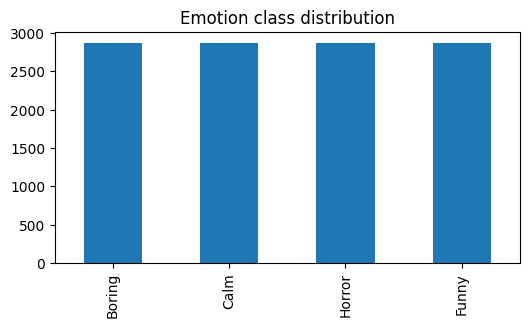

In [11]:
# Class distribution
label_counts = pd.Series(y).value_counts().sort_index()
label_counts.index = [idx2label[i] for i in label_counts.index]
label_counts.plot.bar(figsize=(6, 3))
plt.title("Emotion class distribution")
plt.show()

A non‑linear 2‑D projection can hint whether the chosen features carry emotion‑specific structure.

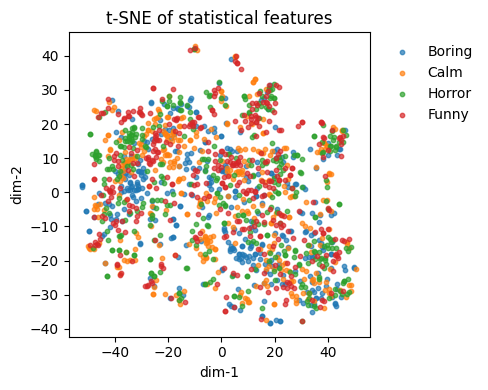

In [12]:
# Sample for speed
sample_idx = np.random.RandomState(RANDOM_SEED).choice(
    len(X_stat), size=1500, replace=False
)
X_sample = X_stat[sample_idx]
y_sample = y[sample_idx]
tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=RANDOM_SEED,
    init="pca",
    learning_rate="auto",
)
emb = tsne.fit_transform(X_sample)
plt.figure(figsize=(5, 4))
palette = sns.color_palette("Set2", n_colors=len(idx2label))
for i, lab in idx2label.items():
    plt.scatter(
        emb[y_sample == i, 0], emb[y_sample == i, 1], s=10, label=lab, alpha=0.7
    )
plt.legend(frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.title("t-SNE of statistical features")
plt.xlabel("dim-1")
plt.ylabel("dim-2")
plt.tight_layout()
plt.show()

We use the silhouette plot to quantitatively assess how well each sample fits its assigned emotion cluster versus other clusters, revealing whether our feature space truly separates the classes.

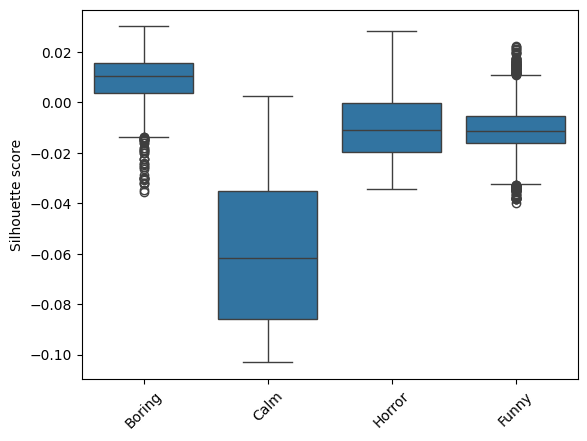

In [13]:
sil_vals = silhouette_samples(X_stat, y)
sns.boxplot(x=[idx2label[i] for i in y], y=sil_vals)
plt.ylabel("Silhouette score")
plt.xticks(rotation=45)
plt.show()

## 4 Group‑aware train/test split

In [36]:
# One full CSV per split (no leakage)
gss = GroupShuffleSplit(test_size=0.2, random_state=RANDOM_SEED)
train_idx, test_idx = next(gss.split(X_stat, y, groups=groups))

idx_train, idx_test = train_idx, test_idx
y_train, y_test = y[idx_train], y[idx_test]

splits = {
    "stat": (X_stat[idx_train], X_stat[idx_test]),
    "comb": (X_comb[idx_train], X_comb[idx_test]),
    "raw": (X_raw[idx_train], X_raw[idx_test]),
}
print("Train windows:", len(idx_train), "| Test windows:", len(idx_test))


# Helper for confusion matrices
def plot_cm(y_true, y_pred, title):
    labels = [idx2label[i] for i in range(len(idx2label))]
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    cmn = cm / cm.sum(1, keepdims=True)
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cmn, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, cbar=False
    )
    plt.title(title)
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.show()

Train windows: 9108 | Test windows: 2376


## 5 Random Forest

RF accuracy: 73.48484848484848


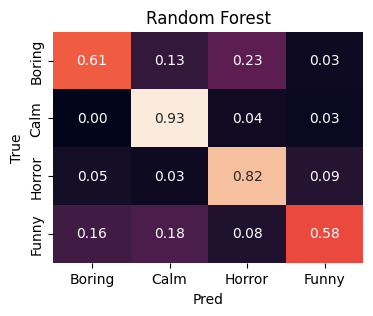

In [15]:
X_tr, X_te = splits["stat"]
rf = Pipeline(
    [
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler()),
        (
            "rf",
            RandomForestClassifier(
                n_estimators=400,
                class_weight="balanced",
                n_jobs=-1,
                random_state=RANDOM_SEED,
            ),
        ),
    ]
)
rf.fit(X_tr, y_train)
rf_pred = rf.predict(X_te)
print("RF accuracy:", accuracy_score(y_test, rf_pred) * 100)
plot_cm(y_test, rf_pred, "Random Forest")

## 6 Save

In [16]:
MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
joblib.dump(rf, MODELS_DIR / "rf_stat.joblib")
print("Models saved →", MODELS_DIR.resolve())

Models saved → C:\Users\urban\Desktop\Studia\II_degree\sem_1\MP\project\emotion-recognition\models


### TODO

## 7 Deep Learning – CIT‑EmotionNet
Implementacja konwolucyjno‑transformerowej sieci **CIT‑EmotionNet** (Lu et al., 2025) na surowych oknach EEG (`X_raw`). Architektura łączy **lokalne** cechy przestrzenno‑czasowe (CNN) z **globalnymi** zależnościami (Vision Transformer) poprzez moduł interakcji.

**Literatura:**  
- Wei Lu, Hua Ma, Tien‑Ping Tan – *“CIT‑EmotionNet: CNN Interactive Transformer Network for EEG Emotion Recognition.”* PeerJ Computer Science (2025) [[arXiv 2305.05548](https://arxiv.org/abs/2305.05548)]

In [ ]:
# 🛠 Dependencies
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np, math, tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------------------------------------------
# CNN branch: captures local spatial‑temporal patterns
# ------------------------------------------------------------------
class CNNBranch(nn.Module):
    """Two‑layer CNN producing a fixed‑length feature vector."""
    def __init__(self, in_ch: int = 1, hidden: int = 64, feat_dim: int = 128):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, hidden, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(hidden, hidden * 2, kernel_size=3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten()
        )
        self.fc = nn.Linear(hidden * 2 * 4 * 4, feat_dim)

    def forward(self, x):              # x: (B, 1, H, W)
        x = self.features(x)
        return self.fc(x)              # (B, feat_dim)

# ------------------------------------------------------------------
# Transformer branch: captures global dependencies
# ------------------------------------------------------------------
class TransformerBranch(nn.Module):
    """Lightweight ViT‑style encoder on 2‑D EEG 'images'."""
    def __init__(self, img_h: int, img_w: int, patch: int,
                 dim: int = 128, depth: int = 2, heads: int = 4):
        super().__init__()
        assert img_h % patch == 0 and img_w % patch == 0, "Image dims must be divisible by patch size"
        self.patch_embed = nn.Conv2d(1, dim, kernel_size=patch, stride=patch)
        self.num_patches = (img_h // patch) * (img_w // patch)

        # learnable CLS token & positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))
        self.pos = nn.Parameter(torch.zeros(1, self.num_patches + 1, dim))
        nn.init.trunc_normal_(self.pos, std=0.02)

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

    def forward(self, x):              # x: (B, 1, H, W)
        B = x.size(0)
        x = self.patch_embed(x).flatten(2).transpose(1, 2)   # (B, N, D)

        cls_tokens = self.cls_token.expand(B, -1, -1)        # (B, 1, D)
        x = torch.cat([cls_tokens, x], dim=1)                # prepend CLS

        # handle off‑by‑one mismatch by padding or truncating the positional matrix
        if self.pos.size(1) < x.size(1):
            # repeat last positional vector to extend
            pad = self.pos[:, -1:].expand(-1, x.size(1) - self.pos.size(1), -1).clone()
            pos = torch.cat([self.pos, pad], dim=1)
        else:
            pos = self.pos[:, :x.size(1)]
        x = x + pos

        x = self.encoder(x)
        return x[:, 0]                                       # CLS token feature (B, D)

# ------------------------------------------------------------------
# CIT‑EmotionNet: fuse local + global features
# ------------------------------------------------------------------
class CITEmotionNet(nn.Module):
    def __init__(self, img_h: int, img_w: int, patch: int, num_classes: int, feat_dim: int = 128):
        super().__init__()
        self.cnn = CNNBranch(feat_dim=feat_dim)
        self.vit = TransformerBranch(img_h, img_w, patch, dim=feat_dim)
        self.classifier = nn.Linear(feat_dim, num_classes)

    def forward(self, x):
        local_feat = self.cnn(x)
        global_feat = self.vit(x)
        fused = local_feat + global_feat
        return self.classifier(fused)


In [ ]:
# Dataset wrapper using existing splits (idx_train, idx_test) and X_raw, y
class EEGImageDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()  # (N, ch, time)
        self.y = torch.from_numpy(y).long()
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        img = self.X[idx][None]  # add 1 channel dim -> (1, H, W)
        return img, self.y[idx]

# Infer image dims and suitable patch size
img_h, img_w = int(X_raw.shape[1]), int(X_raw.shape[2])
def choose_patch(h, w):
    for p in [16, 8, 4, 2, 1]:
        if h % p == 0 and w % p == 0:
            return p
    return 1
patch = choose_patch(img_h, img_w)
print(f'Image size: {img_h}×{img_w}, patch={patch}')

train_ds = EEGImageDataset(X_raw[idx_train], y[idx_train])
test_ds  = EEGImageDataset(X_raw[idx_test],  y[idx_test])
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=256)

model = CITEmotionNet(img_h, img_w, patch, num_classes=len(idx2label)).to(device)
print('Params:', sum(p.numel() for p in model.parameters())/1e6, 'M')

In [ ]:

import time, math, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

EPOCHS = 20                 # full training run
train_losses, train_accs = [], []
val_losses, val_accs = [], []

def run_epoch(loader, train=False):
    model.train() if train else model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        with torch.set_grad_enabled(train):
            out = model(xb)
            loss = F.cross_entropy(out, yb)
        if train:
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        total += yb.size(0)
        correct += out.argmax(1).eq(yb).sum().item()
        loss_sum += loss.item() * yb.size(0)
    return loss_sum/total, correct/total

start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_dl, train=True)
    va_loss, va_acc = run_epoch(test_dl,  train=False)
    train_losses.append(tr_loss); train_accs.append(tr_acc)
    val_losses.append(va_loss);   val_accs.append(va_acc)
    print(f"Epoch {epoch:2d}/{EPOCHS} | train acc {tr_acc*100:5.1f}% | val acc {va_acc*100:5.1f}%")
print(f"Training finished in {(time.time()-start):.1f} s")

# ------------------------------------------------------------------
# Confusion matrix on validation set
# ------------------------------------------------------------------
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        preds = model(xb.to(device)).argmax(1).cpu()
        all_preds.append(preds); all_true.append(yb)
all_preds = torch.cat(all_preds).numpy()
all_true  = torch.cat(all_true).numpy()

cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=[idx2label[i] for i in range(len(idx2label))])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, colorbar=False)
plt.title("Validation Confusion Matrix")

print("\nClassification report:\n", classification_report(all_true, all_preds, target_names=[idx2label[i] for i in range(len(idx2label))]))


# ------------------------------------------------------------------
# Save final trained weights
# ------------------------------------------------------------------
torch.save(model.state_dict(), 'cit_emotionnet_trained.pth')
print('Model weights saved to cit_emotionnet_trained.pth')
